# Packages

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset

To be familiar with the dataset, load the data by running the cell below.

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('./dataset')

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


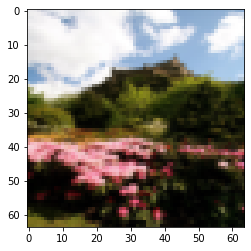

In [5]:
# Example of a picture
index = 32
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [8]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [9]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":
    """
    global parameters
    np.random.seed(1)
    parameters = {}

    parameters["W1"] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
    parameters["b1"] = np.random.randn(layer_dims[1], 1) * 0.01
    parameters["W2"] = np.random.randn(layer_dims[2], layer_dims[1]) * 0.01
    parameters["b2"] = np.random.randn(layer_dims[2], 1) * 0.01

    return parameters

In [10]:
def linear_activation_forward(X, parameters):
    """
    Implement the forward propagation

    Arguments:
    X -- input data:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":

    Returns:
    AL -- output of the forward propogation
    """
    Z1 = np.dot(parameters["W1"], X) + parameters["b1"]
    A = np.maximum(0, Z1)
    Z2 = np.dot(parameters["W2"], A) + parameters["b2"]
    AL = 1/(1 + np.exp(-Z2))
    global AZ
    AZ = (A, Z1)
    return AL

In [11]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cost
    """
    m = Y.shape[1]
    cost = -1 / m * np.sum(np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log(1-AL)))
    cost = np.squeeze(cost)
    
    return cost

In [12]:
def linear_activation_backward(X, cost):
    """
    Implement the backward propagation
    
    Arguments:
    X -- input data
    cost -- cost
    
    Returns:
    grads --  A dictionary with the gradients
    grads["dW1"]
    grads["db1"]
    grads["dW2"]
    grads["db2"]
    """
    global AZ, parameters, costs

    AL = linear_activation_forward(X, parameters)
    Y = np.copy(train_y)
    Y = Y.reshape(AL.shape)

    costs.append(cost)

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    dZ2 = dAL * AL * (1 - AL)
    m = AZ[0].shape[1]
    dW2 = 1./m * np.dot(dZ2, AZ[0].T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    dA = np.dot(parameters["W2"].T, dZ2)
    dZ1 = np.array(dA, copy=True)
    dZ1[AZ[1] <= 0] = 0
    m = X.shape[1]
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)

    grads["dW1"] = dW1
    grads["db1"] = db1
    grads["dW2"] = dW2
    grads["db2"] = db2

    return grads

In [13]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
            parameters["W1"]
            parameters["b1"]
            parameters["W2"]
            parameters["b2"]
    """
    parameters["W1"] = parameters["W1"] - learning_rate * grads["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * grads["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * grads["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * grads["db2"]
    
    return parameters


In [14]:
def predict(test_x, test_y, parameters):
    """
    Predict test data
    test_x -- test data
    test_y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    
    Returns:
    accuracy -- accuracy of your model
    """
    total = test_y.shape[1]
    AL = linear_activation_forward(test_x, parameters)
    AL[AL > 0.5] = 1
    AL[AL <= 0.5] = 0
    compare = np.equal(AL, test_y)
    TP = np.count_nonzero(compare)
    accuracy = (TP / total) * 100
    return accuracy

In [15]:
def plot_loss(costs):
    """
    Plot loss
    costs - cost of each iteration
    
    """ 
    plt.plot(np.squeeze(costs))
    plt.show()

In [16]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 10000):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    global grads, costs
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL = linear_activation_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = linear_activation_backward(X, cost)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    return parameters

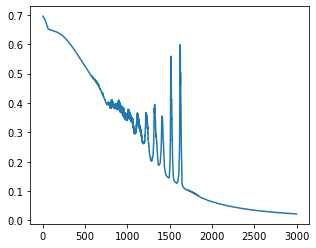

72.0


In [17]:
def main():
    parameters = two_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000)
    plot_loss(costs)
    accuracy = predict(test_x, test_y, parameters)
    print(accuracy)

main()